[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/direct_reconstruction.ipynb) [![Download notebook](https://img.shields.io/badge/Download-notebook-blue?logo=jupyter)](path:direct_reconstruction.ipynb)

In [1]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebooks]

# Direct reconstruction of 2D golden angle radial data
Here we use the `~mrpro.algorithms.reconstruction.DirectReconstruction` class to perform a basic reconstruction of
2D radial data.
A *direct* reconstruction uses the density compensated adjoint of the acquisition operator to obtain the images.

## Using `~mrpro.algorithms.reconstruction.DirectReconstruction`
We use the `~mrpro.algorithms.reconstruction.DirectReconstruction` class to reconstruct images from 2D radial data.
`~mrpro.algorithms.reconstruction.DirectReconstruction` estimates sensitivity maps, density compensation factors, etc.
and performs an adjoint Fourier transform.
This the simplest reconstruction method in our high-level interface to the reconstruction pipeline.

### Load the data
We load in the Data from the ISMRMRD file. We want use the trajectory that is stored also stored the ISMRMRD file.
This can be done by passing a `~mrpro.data.traj_calculators.KTrajectoryIsmrmrd` object to
`~mrpro.data.KData.from_file` when loading creating the `~mrpro.data.KData`.

In [2]:
# Download raw data from Zenodo
import tempfile
from pathlib import Path

import zenodo_get

dataset = '14617082'

tmp = tempfile.TemporaryDirectory()  # RAII, automatically cleaned up
data_folder = Path(tmp.name)
zenodo_get.zenodo_get([dataset, '-r', 5, '-o', data_folder])  # r: retries

Title: 2D Radial MR raw data and Pulseq sequences
Keywords: 
Publication date: 2025-01-08
DOI: 10.5281/zenodo.14617082
Total size: 18.7 MB

Link: https://zenodo.org/records/14617082/files/radial2D_24spokes_golden_angle_with_traj.h5   size: 858.7 kB



Checksum is correct. (9a82b5f9c6f27a3db64fd8f7be65cfa3)

Link: https://zenodo.org/records/14617082/files/radial2D_24spokes_golden_angle.seq   size: 29.3 kB



Checksum is correct. (d48ba3340d511a7e24dfc69031a3b6ac)

Link: https://zenodo.org/records/14617082/files/radial2D_402spokes_golden_angle.seq   size: 172.2 kB



Checksum is correct. (ff682e21d7d2434dc5b672523dfeacec)

Link: https://zenodo.org/records/14617082/files/radial2D_96spokes_golden_angle_with_traj.h5   size: 3.4 MB



Checksum is correct. (9fc6d03790b1cf293cbd83939a1dd752)

Link: https://zenodo.org/records/14617082/files/radial2D_402spokes_golden_angle_with_traj.h5   size: 14.2 MB



Checksum is correct. (54d083c0040d3674317006cbaaa95420)

Link: https://zenodo.org/records/14617082/files/radial2D_96spokes_golden_angle.seq   size: 55.9 kB



Checksum is correct. (449434bf7b5e609d09cf5d42cf27c7f3)
All files have been downloaded.


In [3]:
import mrpro
import torch

trajectory_calculator = mrpro.data.traj_calculators.KTrajectoryIsmrmrd()
kdata = mrpro.data.KData.from_file(data_folder / 'radial2D_402spokes_golden_angle_with_traj.h5', trajectory_calculator)

## Setup the DirectReconstruction instance
We create a `~mrpro.algorithms.reconstruction.DirectReconstruction` and supply ``kdata``.
`~mrpro.algorithms.reconstruction.DirectReconstruction` uses the information in ``kdata`` to
 setup a Fourier transfrm, density compensation factors, and estimate coil sensitivity maps.
(See the *Behind the scenes* section for more details.)

```{note}
You can also directly set the Fourier operator, coil sensitivity maps, density compensation factors, etc.
of the reconstruction instance.
```

In [4]:
reconstruction = mrpro.algorithms.reconstruction.DirectReconstruction(kdata)

## Perform the reconstruction
The reconstruction is performed by calling the passing the k-space data.
```{note}
Often, the data used to obtain the meta data for constructing the reconstruction instance
is the same as the data passed to the reconstruction.
But you can also different to create the coil sensitivity maps, dcf, etc.
than the data that is passed to the reconstruction.
```

In [5]:
img = reconstruction(kdata)

### Display the reconstructed image
We now got in `~mrpro.data.IData` object containing a header and the image tensor.
We display the reconstructed image using matplotlib.

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


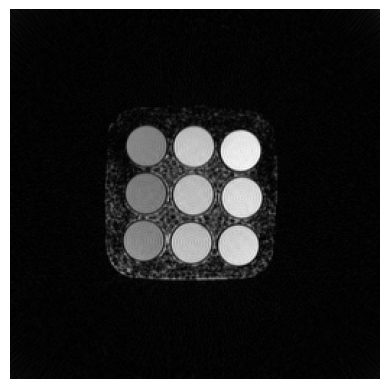

In [6]:
import matplotlib.pyplot as plt

# If there are multiple slices, ..., only the first one is selected
first_img = img.rss()[0, 0]  #  images, z, y, x
plt.imshow(first_img, cmap='gray')
plt.axis('off')
plt.show()

## Behind the scenes
We now peek behind the scenes to see what happens in the `~mrpro.algorithms.reconstruction.DirectReconstruction`
class, and perform all steps manually:
- Calculate density compensation factors
- Setup Fourier operator
- Obtain coil-wise images
- Calculate coil sensitivity maps
- Perform direct reconstruction

### Calculate density compensation using the trajectory
We use a Voronoi tessellation of the trajectory to calculate the `~mrpro.data.DcfData` and obtain
a `~mrpro.operators.DensityCompensationOp` operator.

In [7]:
dcf_operator = mrpro.data.DcfData.from_traj_voronoi(kdata.traj).as_operator()

### Setup Fourier Operator
Next, we create the Fourier operator. We can just pass the ``kdata`` object to the constructor of the
`~mrpro.operators.FourierOp`, and the trajectory and header information is used to create the operator. We want the
to use the adjoint density compensated Fourier operator, so we perform a composition with ``dcf_operator``
and use the `~mrpro.operators.FourierOp.H` property of the operator to obtain its adjoint.

In [8]:
fourier_operator = dcf_operator @ mrpro.operators.FourierOp.from_kdata(kdata)
adjoint_operator = fourier_operator.H

### Calculate coil sensitivity maps
Coil sensitivity maps are calculated using the walsh method (See `~mrpro.data.CsmData` for other available methods).
We first need to calculate the coil-wise images, which are then used to calculate the coil sensitivity maps.

In [9]:
img_coilwise = mrpro.data.IData.from_tensor_and_kheader(*adjoint_operator(kdata.data), kdata.header)
csm_operator = mrpro.data.CsmData.from_idata_walsh(img_coilwise).as_operator()

### Perform Direct Reconstruction
Finally, the direct reconstruction is performed and an `~mrpro.data.IData` object with the reconstructed
image is returned. We update the ``adjoint_operator`` to also include the coil sensitivity maps, thus
performing the coil combination.

In [10]:
adjoint_operator = (fourier_operator @ csm_operator).H
img_manual = mrpro.data.IData.from_tensor_and_kheader(*adjoint_operator(kdata.data), kdata.header)

## Further behind the scenes
There is also a even more manual way to perform the direct reconstruction. We can set up the Fourier operator by
passing the trajectory and matrix sizes.

In [11]:
fourier_operator = mrpro.operators.FourierOp(
    recon_matrix=kdata.header.recon_matrix,
    encoding_matrix=kdata.header.encoding_matrix,
    traj=kdata.traj,
)

We can call one of the algorithms in `mrpro.algorithms.dcf` to calculate the density compensation factors.

In [12]:
kykx = torch.stack((kdata.traj.ky[0, 0], kdata.traj.kx[0, 0]))
dcf_tensor = mrpro.algorithms.dcf.dcf_2d3d_voronoi(kykx)

We use these DCFs to weight the k-space data before performing the adjoint Fourier transform. We can also call
`~mrpro.operators.FourierOp.adjoint` on the Fourier operator instead of obtaining an adjoint operator.

In [13]:
(img_tensor_coilwise,) = fourier_operator.adjoint(dcf_tensor * kdata.data)

Next, we calculate the coil sensitivity maps by using one of the algorithms in `mrpro.algorithms.csm` and set
up a `~mrpro.operators.SensitivityOp` operator.

In [14]:
csm_data = mrpro.algorithms.csm.walsh(img_tensor_coilwise[0], smoothing_width=5)
csm_operator = mrpro.operators.SensitivityOp(csm_data)

Finally, we perform the coil combination of the coil-wise images and obtain final images.

In [15]:
(img_tensor_coilcombined,) = csm_operator.adjoint(img_tensor_coilwise)
img_more_manual = mrpro.data.IData.from_tensor_and_kheader(img_tensor_coilcombined, kdata.header)

### Check for equal results
The 3 versions result should in the same image data.

In [16]:
# If the assert statement did not raise an exception, the results are equal.
torch.testing.assert_close(img.data, img_manual.data)
torch.testing.assert_close(img.data, img_more_manual.data, atol=1e-4, rtol=1e-4)